# OptTurb
Is based on a optimization campaign to design a turbine for Purdue AeroThermal Experimental Lab. It is based on a 1D meanline code; however, the full radial equilibrium equations are solved.

The lab consists of storage of high pressure air at 138 bar paired to a heater allowing temperatures to reach 1090K. This is the exhausted to either athmosphere or a vacuum tank.
![zucrow labs](https://github.com/nasa/turbo-design/blob/main/examples/optturb-turbine/images/zucrow.png?raw=true)

A meanline code was used to design an optimal velocity triangle for a turbine given the range of operating conditions of the facility.

[Design Spreadsheet](https://github.com/nasa/turbo-design/blob/main/examples/optturb-turbine/optturb-fixed_pressure_loss2.xlsm)


In [68]:
# Installing the package
# !pip install turbo-design
import os, sys 
sys.path.insert(0, '../../')

In [69]:
from turbodesign import TurbineSpool, Inlet, RowType, BladeRow, Passage, Outlet, PassageType
from turbodesign.enums import MassflowConstraint
from turbodesign.coolant import Coolant
import numpy as np
from cantera import Solution

In [70]:
#%% Define the Passage
# Geometry from OptTurb
rmean = 0.389 # meters
H1 = 0.04 # meters
H2 = 1.159*H1
H3 = 1.317*H2
cax = (H1+H2+H3)/3

# Inlet, Stator Inlet, Stator Exit, Rotor Exit
rhub = [rmean-H1/2,rmean-H1/2,rmean-H2/2,rmean-H3/2]
rshroud = [rmean+H1/2,rmean+H1/2,rmean+H2/2,rmean+H3/2]
xhub = np.array([-cax, 0.0, cax, 2*cax])
xshroud = np.array([-cax, 0.0, cax, 2*cax])
axial_len = xhub[-1]-xhub[0]

passage = Passage(xhub,rhub,
                 xshroud,rshroud,
                 passageType=PassageType.Axial)

#%% Design Conditions
Design_RPM = 7500
P0 = 500000     # Pascal
T0 = 676.3      # Kelvin

# Fluid
fluid = Solution('air.yaml')
fluid.TP = T0, P0 # Use pascal for cantera
print(f"Coefficient of Pressure [J/Kg] {fluid.cp:0.4f}")

#%% Defining the Inlet
inlet = Inlet(M=0.2,
                 P0=[P0],
                 T0=[T0],
                 beta=[0],
                 fluid=fluid,
                 percent_radii=0.5,
                 axial_location=cax/axial_len)
outlet = Outlet(P=P0/3.96,percent_radii=0.5,num_streamlines=3)

stator1 = BladeRow(row_type=RowType.Stator,axial_location=2*cax/axial_len)
rotor1 = BladeRow(row_type=RowType.Rotor,axial_location=3*cax/axial_len)

stator1.axial_chord = cax # Set an axial chord. Used for plotting
rotor1.axial_chord = cax

# Coolant Definition: Use Kelvin and Pascal
stator1.coolant = Coolant(fluid, T0=616*0.555556, P0= 50.6 * 6894.76, massflow_percentage=0)
rotor1.coolant = Coolant(fluid, 622*0.555556, 50.3 * 6894.76,massflow_percentage=0)

# Add in turning angles
stator1.beta2_metal = [73,73,73] # Angle, hub,mean,tip
rotor1.beta2_metal = [-67.6,-67.6,-67.6] # Angle, hub,mean,tip

# Coolant: Use Kelvin and Pascal
massflow = 35.9 # kg/s, guessed value

Coefficient of Pressure [J/Kg] 1066.8767


Turbine example contains many different loss models. Two types of models currently supported are enthalpy based and pressure loss based. Users can write their own loss models, see source code for more information.

In [71]:
# Commented out because you need to generate a pickle file for other loss models.
# To do that, go into craigcox folder and run `python build_dataset.py`
# There is an auto download but depending on the python version, the pickle file downloaded may not read.

# from turbodesign.loss.turbine import CraigCox, AinleyMathieson, FixedEfficiency, KrackerOkapuu, Traupel, TD2, FixedPressureLoss
from turbodesign.loss.turbine import FixedPressureLoss
stator1.loss_model = FixedPressureLoss(0.221)
rotor1.loss_model = FixedPressureLoss(0.30)

In [72]:
# Define the spool
spool = TurbineSpool(passage=passage,
            rpm=Design_RPM,
            num_streamlines=3,
            massflow=massflow,
            rows=[inlet,stator1,rotor1,outlet])
spool.fluid = fluid
spool.massflow_constraint = MassflowConstraint.BalanceMassFlow # Fixes the exit angle and changes degree of reaction


Find average P in between stages


0.3044582472000672
0.4555417527999326
0.5489164944001345
0.606625258399798
0.6341377797393396
0.5934786065495046
0.5764573943189298
0.5919401633713963
0.5860262718333191
0.5909279483313671
0.5920995038981798
0.5918130031862433
0.5919735054846211
0.5920068475983405

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  0.0001 )
0.5919735054846211
0.5919735054846211
Massflow convergenced error:0.039474918361428024


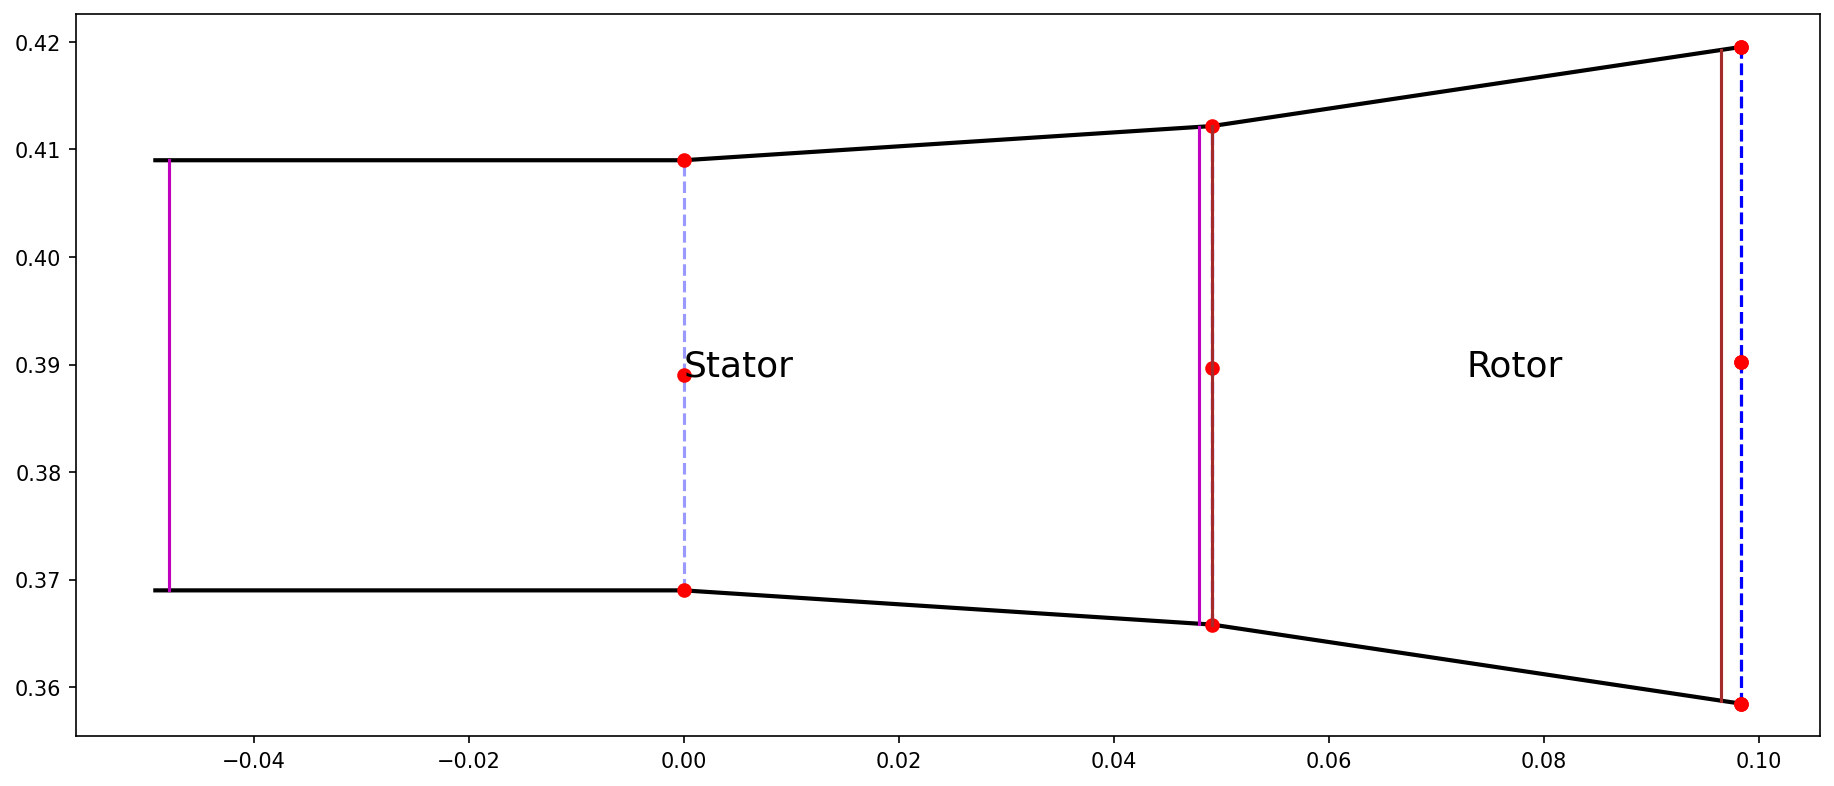

AttributeError: 'TurbineSpool' object has no attribute 'plot_geometry'

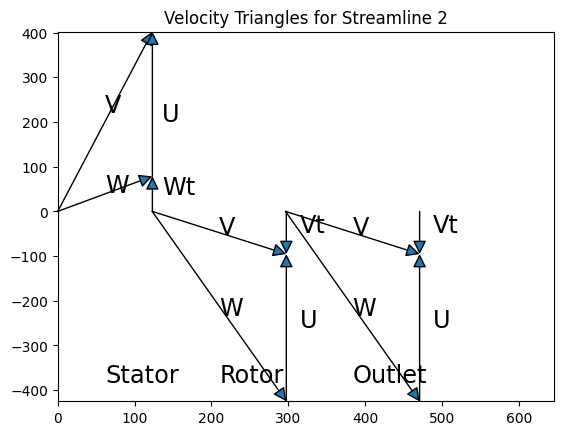

In [ ]:
# spool.plot_geometry()
spool.solve() # This also initializes streamlines
spool.export_properties("optturb.json")
spool.plot()
spool.plot_velocity_triangles()
